In [15]:
import aim
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from sklearn.manifold import TSNE
from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import v2

import sys

sys.path.append("..")

from source.model import *

In [16]:
run_hash = "c2d94fea8bb94925bfaafb30"

path_softlock = Path("..") / ".aim" / "locks" / f"{run_hash}.softlock"
if path_softlock.exists():
    path_softlock.unlink()

repo_path = ".."
run = aim.Run(run_hash, repo=repo_path)
hparams = run["hparams"]
hparams

{'batch_size': 128,
 'dataset': 'fashion-mnist',
 'input_dim': 784,
 'kl_lambda': 1.0,
 'latent_dim': 10,
 'lr_decay_factor': 0.95,
 'lr_decay_rate': 10,
 'lr': 0.0002,
 'n_epochs': 200,
 'num_workers': 4,
 'random_seed': 10,
 'save_every': 50,
 'valid_every': 10}

In [17]:
random_state = 42

path_ckpts = Path("..") / "weights"

config = {
    "model_type": VAE,
    "from_epochs": [0, 50, 100, 150],
    "batch_size": 4096,
    "n_samples": 8192,
}

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
if hparams["dataset"] == "mnist":
    transform = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Lambda(lambda x: torch.flatten(x)),
        ]
    )
    train_dataset = MNIST("../.data", transform=transform, train=True, download=True)
    valid_dataset = MNIST("../.data", transform=transform, train=False, download=True)
    dataset = ConcatDataset([train_dataset, valid_dataset])

elif hparams["dataset"] == "fashion-mnist":
    transform = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Lambda(lambda x: torch.flatten(x)),
        ]
    )
    train_dataset = FashionMNIST(
        "../.data", transform=transform, train=True, download=True
    )
    valid_dataset = FashionMNIST(
        "../.data", transform=transform, train=False, download=True
    )
    dataset = ConcatDataset([train_dataset, valid_dataset])

dataset = torch.utils.data.random_split(
    dataset, [config["n_samples"], len(dataset) - config["n_samples"]]
)[0]

dataloader = DataLoader(dataset, batch_size=config["batch_size"], num_workers=0)

paths_ckpts = [path_ckpts / f"{run_hash}_{e}.pth" for e in config["from_epochs"]]

outputs = {}
ys = []

for epoch, path_ckpt in zip(config["from_epochs"], paths_ckpts):
    outputs[epoch] = []

    if config["model_type"] == VAE:
        model = VAE(hparams["input_dim"], hparams["latent_dim"], hparams["kl_lambda"])

    elif config["model_type"] == VaDE:
        model = VAE(hparams["input_dim"], hparams["latent_dim"], hparams["n_clusters"])

    model.eval()
    ckpt = torch.load(path_ckpt)
    model.load_state_dict(ckpt)
    model = model.to(device)

    for x, y in tqdm(dataloader):
        x, y = x.to(device), y

        with torch.no_grad():
            z, _ = model.encoder(x)
            outputs[epoch].append(z)

        if epoch == config["from_epochs"][0]:
            ys.append(y)

    outputs[epoch] = torch.cat(outputs[epoch]).numpy(force=True)
ys = torch.cat(ys).numpy(force=True)

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


In [19]:
tsne_embeds = {}

for epoch, embeds in outputs.items():
    tsne = TSNE(random_state=random_state, verbose=1)
    tsne_embeds[epoch] = tsne.fit_transform(embeds)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8192 samples in 0.010s...
[t-SNE] Computed neighbors for 8192 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8192
[t-SNE] Computed conditional probabilities for sample 2000 / 8192
[t-SNE] Computed conditional probabilities for sample 3000 / 8192
[t-SNE] Computed conditional probabilities for sample 4000 / 8192
[t-SNE] Computed conditional probabilities for sample 5000 / 8192
[t-SNE] Computed conditional probabilities for sample 6000 / 8192
[t-SNE] Computed conditional probabilities for sample 7000 / 8192
[t-SNE] Computed conditional probabilities for sample 8000 / 8192
[t-SNE] Computed conditional probabilities for sample 8192 / 8192
[t-SNE] Mean sigma: 0.202565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.603203
[t-SNE] KL divergence after 1000 iterations: 1.034422
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8192 samples in 0.009s...
[t-SNE] Computed nei

In [20]:
dfs = []

for epoch, tsne_emb in tsne_embeds.items():
    df = pd.DataFrame(tsne_emb, columns=["TSNE1", "TSNE2"])
    df["group"] = f"Epoch: {epoch}"
    df["Class"] = ys
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

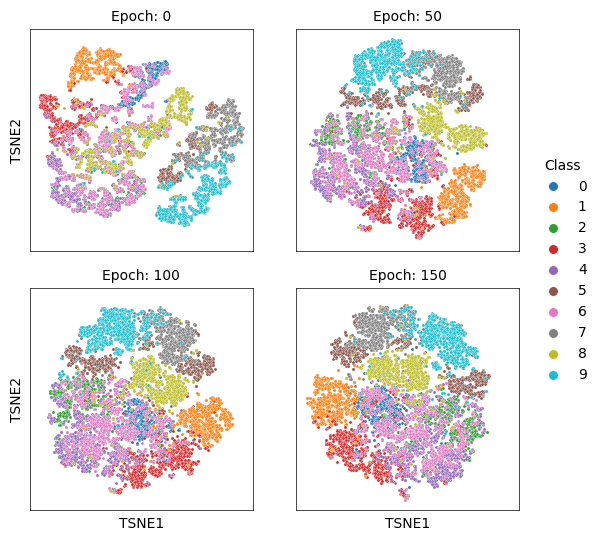

In [21]:
g = sns.FacetGrid(df, col="group", hue="Class", col_wrap=2, legend_out=True)

g.map_dataframe(
    sns.scatterplot, x="TSNE1", y="TSNE2", s=5, edgecolor="w", linewidth=0.2
)

g.set_titles(col_template="{col_name}")
g.tight_layout()
g.add_legend(markerscale=3)

for ax in g.axes.flat:
    ax.set_aspect("equal")  # Ensure the aspect ratio is equal to make the plots square
    ax.tick_params(
        left=False, bottom=False, labelleft=False, labelbottom=False
    )  # Disable ticks and tick labels
    # Add a border around each subplot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(0.5)

plt.subplots_adjust(top=0.9)
plt.show()